# C. Train Models and Compare Them

In [1]:
from pathlib import Path
import itertools 
from rasa.shared.nlu.training_data.training_data import TrainingData

from framework.utils import rasa_utils, eda_utils, split_utils

/Users/kabu/Documents/workspace/rasa2/.venv/lib/python3.8/site-packages/future/standard_library/__init__.py:65: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


## Update Carbon Bot Configuration
----

In [2]:
CARBON_BOT = Path('../../../../carbon-bot-e2e')

#### Original Carbon Bot Config

In [3]:
!cat {CARBON_BOT}/config.yml

language: en

pipeline:
- name: ConveRTTokenizer
- name: ConveRTFeaturizer
  model_url: https://github.com/davidalami/ConveRT/releases/download/1.0/nocontext_tf_model.tar.gz
- name: CountVectorsFeaturizer
- name: CountVectorsFeaturizer
  analyzer: char_wb
  min_ngram: 1
  max_ngram: 4
- name: RegexFeaturizer
- name: LexicalSyntacticFeaturizer
- name: DIETClassifier
  epochs: 60
  scale_loss: False
  connection_density: 0.7
  transformer_size: 512
  BILOU_flag: True
- name: ResponseSelector
  epochs: 50
- name: EntitySynonymMapper

policies:
- name: MemoizationPolicy
  max_history: 5
- name: TEDPolicy
  max_history: 5
  batch_strategy: balanced
  epochs: 300 
  random_seed: 666
  evaluate_on_num_examples: 0
  enable_fallback_prediction: False
- name: RulePolicy


#### Updated Rasa3 Config

In [4]:
!cat ./config.yml

recipe: default.v1
language: en

pipeline:
- name: WhitespaceTokenizer
- name: ConveRTFeaturizer
  model_url: https://github.com/davidalami/ConveRT/releases/download/1.0/nocontext_tf_model.tar.gz
- name: CountVectorsFeaturizer
- name: CountVectorsFeaturizer
  analyzer: char_wb
  min_ngram: 1
  max_ngram: 4
- name: RegexFeaturizer
- name: LexicalSyntacticFeaturizer
- name: DIETClassifier
  epochs: 60
  scale_loss: False
  connection_density: 0.7
  transformer_size: 512
  BILOU_flag: True

policies:

## Test 1: Train with/without Noisy data and Evaluate on Hold Outs
---

### Create Hold Outs

In [5]:
training_data = {name : rasa_utils.load_nlu_data(f'./{name}.yml') for name in ['clean', 'noisy']}

Split each dataset

In [6]:
splits_per_type = dict()
for type_, td in training_data.items():
    (train, test), _ = split_utils.stratified_split_for_nlu_data(
        nlu_data=td, labels = [str(message.get('intent')) for message in td.intent_examples], test_fraction=0.2, random_seed=123)
    splits_per_type[type_] = {'train' : train, 'test' : test}

Recombine results

In [7]:
combined_splits = {
    split_name : TrainingData(
        training_examples=list(itertools.chain.from_iterable(
            [splits_per_type[type_][split_name].training_examples for type_ in splits_per_type]
        ))
    ) 
    for split_name in ['train', 'test']
}    

Write to disk

In [8]:
!mkdir -p splits

In [9]:
for split_name in combined_splits:
    combined_splits[split_name].persist_nlu(f"./splits/{split_name}_noisy-and-clean.yml")
for type_ in splits_per_type:
    for split_name in splits_per_type[type_]:
        splits_per_type[type_][split_name].persist_nlu(f"./splits/{split_name}_{type_}-only.yml")

In [10]:
!ls splits/

test_clean-only.yml       test_noisy-only.yml       train_noisy-and-clean.yml
test_noisy-and-clean.yml  train_clean-only.yml      train_noisy-only.yml


### Train Models

Note: rasa train nlu command still seems to be broken -- will ask for data to be provided via --nlu flag which then does not work

```bash
mkdir -p models

rasa train --fixed-model-name all-data-model --config ./config.yml --data ./splits/train_noisy-and-clean.yml --out ./models/ 

rasa train --fixed-model-name clean-model --config ./config.yml --data ./splits/train_clean-only.yml --out ./models/ 
```

### Predict and Compare 

In [11]:
%%time
%%capture
models = { name :  rasa_utils.RasaModel(model_tar=f"./models/{name}-model.tar.gz") for name in ['clean', 'all-data']}

2022-05-31 13:23:22.658649: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


CPU times: user 30 s, sys: 2.2 s, total: 32.2 s
Wall time: 31.6 s


In [15]:
test_data = {name : eda_utils.load_nlu_data(f'./splits/test_{name}-only.yml') for name in ['clean', 'noisy']}

In [16]:
%%time
for df_name, df in test_data.items():
    for model_name, model in models.items():
        tmp = df['text'].apply(lambda text: model.predict_nlu(text).get('intent'))
        df[f'{model_name}-model-intent'] = tmp.apply(lambda pred :  pred['name'])
        df[f'{model_name}-model-confidence'] = tmp.apply(lambda pred :  pred['confidence'])

CPU times: user 1min 37s, sys: 14.5 s, total: 1min 51s
Wall time: 31.8 s


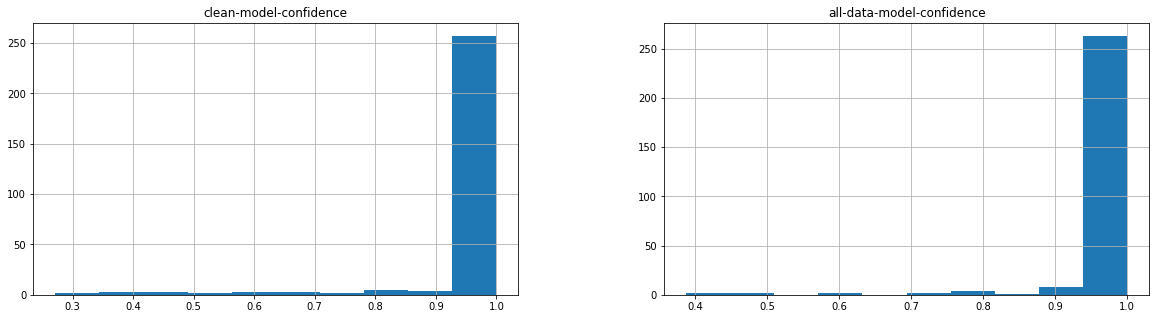

In [26]:
_ = test_data['clean'][['clean-model-confidence', 'all-data-model-confidence']].hist(figsize=(20,5))

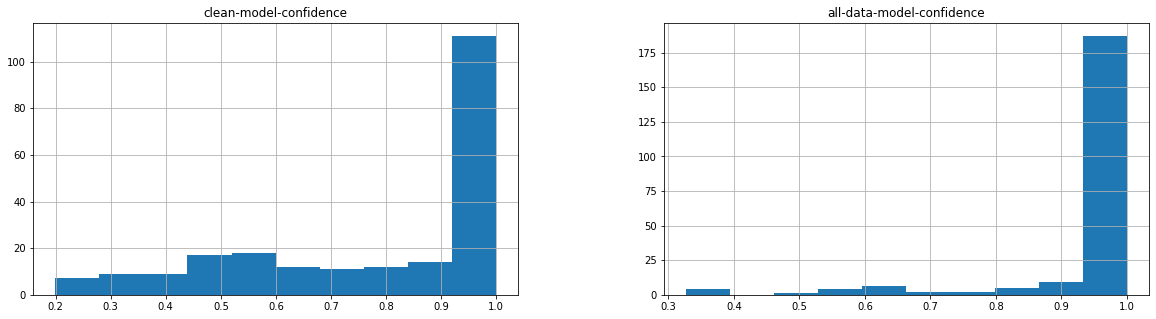

In [27]:
_ = test_data['noisy'][['clean-model-confidence', 'all-data-model-confidence']].hist(figsize=(20,5))

In [24]:
test_data['noisy'][['clean-model-confidence', 'all-data-model-confidence']].describe(
    percentiles=[0.05, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5]
)

,clean-model-confidence,all-data-model-confidence
count,220.000000,220.000000
mean,0.788145,0.952823
std,0.243600,0.126642
min,0.199177,0.326982
5%,0.315593,0.640096
10%,0.410640,0.855854
20%,0.528074,0.976499
25%,0.571530,0.995906
30%,0.632066,0.998666
40%,0.792607,0.999734


## Approach 2: Cross Validation
---

```bash

rasa test nlu --cross-validation --nlu clean.yml --out ./cross-valid-clean

rasa test nlu --cross-validation --nlu ../../../../carbon-bot-e2e/data/nlu.yml  --out ./cross-valid-all
```

In [31]:
import json

In [41]:
results = {}
for key in ['clean', 'all']:
    with open(f'./cross-valid-{key}/intent_report.json') as f:
        results[key] = json.load(f)

In [42]:
results['clean']['weighted avg']

{'precision': 0.9387068876007686,
 'recall': 0.937984496124031,
 'f1-score': 0.9377445983620147,
 'support': 1419}

In [43]:
results['all']['weighted avg']

{'precision': 0.8218753567869241,
 'recall': 0.8224076281287247,
 'f1-score': 0.8210418960634472,
 'support': 2517}